# Agentic RAG From Scratch: Building with LangGraph and Open-Source Models

In this notebook, we'll look under the hood of `create_agent` and build an agentic RAG application **from scratch** using LangGraph's low-level primitives and locally-hosted open-source models.

**Learning Objectives:**
- Understand LangGraph's core constructs: StateGraph, nodes, edges, and conditional routing
- Build a ReAct agent from scratch without high-level abstractions
- Use Ollama to run open-source models locally (gpt-oss:20b + embeddinggemma)
- Set up LangSmith tracing for observability and debugging
- Transition from `aimakerspace` utilities to the LangChain ecosystem

## Table of Contents:

- **Breakout Room #1:** LangGraph Fundamentals & Building Agents from Scratch
  - Task 1: Dependencies & Ollama Setup
  - Task 2: Environment Variables & LangSmith Tracing
  - Task 3: LangGraph Core Concepts (StateGraph, Nodes, Edges)
  - Task 4: Building a ReAct Agent from Scratch
  - Task 5: Adding Tools to Your Agent
  - Question #1 & Question #2
  - Activity #1: Implement a Custom Routing Function

- **Breakout Room #2:** Agentic RAG with Local Models
  - Task 6: Loading & Chunking with LangChain
  - Task 7: Setting up Qdrant with Local Embeddings
  - Task 8: Creating a RAG Tool
  - Task 9: Building Agentic RAG from Scratch
  - Task 10: Comparing Traces in LangSmith
  - Question #3 & Question #4
  - Activity #2: Extend the Agent with Memory

---
# Breakout Room #1
## LangGraph Fundamentals & Building Agents from Scratch

## Task 1: Dependencies & Ollama Setup

Before we begin, make sure you have:

1. **Ollama installed** - Download from [ollama.com](https://ollama.com/)
2. **Ollama running** - Start with `ollama serve` in a terminal
3. **Models pulled** - Run these commands:

```bash
# Chat model for reasoning and generation (~12GB)
ollama pull gpt-oss:20b

# Embedding model for RAG (~622MB)
ollama pull embeddinggemma
```

> **Note**: If you don't have enough RAM/VRAM for `gpt-oss:20b` (requires 16GB+ VRAM or 24GB+ RAM), you can substitute with `llama3.2:3b` or another smaller model.

**📚 Documentation:**
- [Ollama Installation Guide](https://ollama.com/download)
- [gpt-oss Model Card](https://ollama.com/library/gpt-oss)
- [EmbeddingGemma Model Card](https://ollama.com/library/embeddinggemma)
- [langchain-ollama Integration](https://python.langchain.com/docs/integrations/providers/ollama/)

In [1]:
# Core imports we'll use throughout the notebook
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [ ]:
# Verify Ollama is running and models are available
from langchain_ollama import ChatOllama, OllamaEmbeddings

# Test connection to Ollama
try:
    #test_llm = ChatOllama(model="gpt-oss:20b", temperature=0)
    
    test_response = test_llm.invoke("Say 'Ollama is working!' in exactly 3 words.")
    print(f"Chat Model Test: {test_response.content}")
    
    test_embeddings = OllamaEmbeddings(model="embeddinggemma")
    test_vector = test_embeddings.embed_query("test")
    print(f"Embedding Model Test: Vector dimension = {len(test_vector)}")
    print("\nOllama is ready!")
except Exception as e:
    print(f"Error connecting to Ollama: {e}")
    print("\nMake sure:")
    print("1. Ollama is installed: https://ollama.com/")
    print("2. Ollama is running: 'ollama serve'")
    print("3. Models are pulled: 'ollama pull gpt-oss:20b' and 'ollama pull embeddinggemma'")

In [ ]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model='qwen3:4b-instruct') # tried this - quicker inference, but below par results 
llm = ChatOllama(model='gpt-oss:20b', format='json')


## Task 2: LangGraph Core Concepts

In Session 3, we used `create_agent` which abstracts away the complexity. Now let's understand what's happening under the hood!

### LangGraph models workflows as **graphs** with three key components:

### 1. State
A shared data structure that represents the current snapshot of your application:

```python
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]  # Conversation history
```

The `add_messages` **reducer** ensures new messages are appended (not replaced) when the state updates.

### 2. Nodes
Python functions that encode the logic of your agent:
- Receive the current state
- Perform computation or side-effects
- Return an updated state

### 3. Edges
Functions that determine which node to execute next:
- **Normal edges**: Always go to a specific node
- **Conditional edges**: Choose the next node based on state

**📚 Documentation:**
- [LangGraph Low-Level Concepts](https://langchain-ai.github.io/langgraph/concepts/low_level/)
- [LangGraph Quickstart](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [StateGraph API Reference](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph)

In [3]:
# Let's build our first LangGraph workflow - a simple echo graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# Step 1: Define the State
class SimpleState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 2: Define Nodes (functions that process state)
def echo_node(state: SimpleState):
    """A simple node that echoes the last message."""
    last_message = state["messages"][-1]
    echo_response = AIMessage(content=f"You said: {last_message.content}")
    return {"messages": [echo_response]}

# Step 3: Build the Graph
echo_graph = StateGraph(SimpleState)

# Add nodes
echo_graph.add_node("echo", echo_node)

# Add edges (START -> echo -> END)
echo_graph.add_edge(START, "echo")
echo_graph.add_edge("echo", END)

# Compile the graph
echo_app = echo_graph.compile()

print("Simple echo graph created!")

Simple echo graph created!


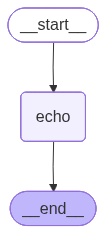

In [4]:
# Visualize the graph structure
try:
    from IPython.display import display, Image
    display(Image(echo_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(echo_app.get_graph().draw_ascii())

In [5]:
# Test the echo graph
result = echo_app.invoke({"messages": [HumanMessage(content="Hello, LangGraph!")]})

print("Conversation:")
for msg in result["messages"]:
    role = "Human" if isinstance(msg, HumanMessage) else "AI"
    print(f"  [{role}]: {msg.content}")

Conversation:
  [Human]: Hello, LangGraph!
  [AI]: You said: Hello, LangGraph!


## Task 3: Building a ReAct Agent from Scratch

Now let's build something more sophisticated: a **ReAct agent** that can:
1. **Reason** about what to do
2. **Act** by calling tools
3. **Observe** results
4. **Repeat** until done

This is exactly what `create_agent` does under the hood. Let's build it ourselves!

### The Agent Loop Architecture

```
                    ┌──────────────┐
                    │    START     │
                    └──────┬───────┘
                           │
                           ▼
                    ┌──────────────┐
             ┌─────►│    agent     │◄────────┐
             │      │  (call LLM)  │         │
             │      └──────┬───────┘         │
             │             │                 │
             │             ▼                 │
             │      ┌──────────────┐         │
             │      │ should_      │         │
             │      │ continue?    │         │
             │      └──────┬───────┘         │
             │             │                 │
             │    tool_calls?                │
             │     │           │             │
             │    YES         NO             │
             │     │           │             │
             │     ▼           ▼             │
             │ ┌────────┐  ┌───────┐         │
             │ │ tools  │  │  END  │         │
             └─┤(execute│  └───────┘         │
               │ tools) ├────────────────────┘
               └────────┘
```

**📚 Documentation:**
- [How to create a ReAct agent from scratch](https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/)
- [ReAct Agent Conceptual Guide](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent)

In [6]:
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

# Step 1: Define the Agent State
class AgentState(TypedDict):
    """The state of our agent - just a list of messages."""
    messages: Annotated[list[BaseMessage], add_messages]

print("AgentState defined with messages field")

AgentState defined with messages field


## Task 4: Adding Tools to Your Agent

Tools are functions that the agent can call. We use the `@tool` decorator and **bind** them to the LLM.

**📚 Documentation:**
- [LangChain Tools Conceptual Guide](https://python.langchain.com/docs/concepts/tools/)
- [@tool Decorator Reference](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html)
- [ToolNode Prebuilt](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode)

In [9]:
# Step 3: Define Tools
@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool list
tools = [calculate, get_current_time]

# Bind tools to the LLM - this tells the LLM about available tools
llm_with_tools = llm.bind_tools(tools)

print("Tools defined and bound to LLM:")
for t in tools:
    print(f"  - {t.name}: {t.description[:50]}...")

Tools defined and bound to LLM:
  - calculate: Evaluate a mathematical expression. Use this for a...
  - get_current_time: Get the current date and time. Use this when the u...


In [10]:
# Step 4: Define the Agent Node (calls the LLM)
SYSTEM_PROMPT = """You are a helpful assistant that can perform calculations and tell the time.
Always use the available tools when appropriate.
Be concise in your responses."""

def agent_node(state: AgentState):
    """The agent node - calls the LLM with the current conversation."""
    # Prepare messages with system prompt
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    
    # Call the LLM
    response = llm_with_tools.invoke(messages)
    
    # Return the response to be added to state
    return {"messages": [response]}

print("Agent node defined")

Agent node defined


In [11]:
# Step 5: Define the Tool Node (executes tools)
# We can use LangGraph's prebuilt ToolNode for convenience
tool_node = ToolNode(tools)

print("Tool node created using ToolNode prebuilt")

Tool node created using ToolNode prebuilt


In [12]:
# Step 6: Define the Conditional Edge (routing logic)
def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """Determine whether to call tools or end the conversation."""
    last_message = state["messages"][-1]
    
    # If the LLM made tool calls, route to tools node
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Otherwise, end the conversation
    return "end"

print("Conditional routing function defined")

Conditional routing function defined


In [13]:
# Step 7: Build the Graph!
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

# Set the entry point
workflow.add_edge(START, "agent")

# Add conditional edge from agent
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",  # If should_continue returns "tools", go to tools node
        "end": END         # If should_continue returns "end", finish
    }
)

# Add edge from tools back to agent (the loop!)
workflow.add_edge("tools", "agent")

# Compile the graph
agent = workflow.compile()

print("ReAct agent built from scratch!")

ReAct agent built from scratch!


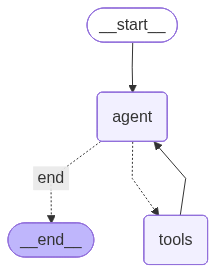

In [14]:
# Visualize our agent
try:
    from IPython.display import display, Image
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(agent.get_graph().draw_ascii())

In [15]:
# Test our agent!
print("Testing our from-scratch agent:")
print("=" * 50)

response = agent.invoke({"messages": [HumanMessage(content="What is 25 * 48?")]})

print("\nConversation:")
for msg in response["messages"]:
    msg_type = type(msg).__name__
    content = msg.content if msg.content else f"[Tool calls: {msg.tool_calls}]" if hasattr(msg, 'tool_calls') and msg.tool_calls else "[No content]"
    print(f"  [{msg_type}]: {content[:200]}")

Testing our from-scratch agent:

Conversation:
  [HumanMessage]: What is 25 * 48?
  [AIMessage]: [Tool calls: [{'name': 'calculate', 'args': {'expression': '25 * 48'}, 'id': 'b33702bb-1c3b-4886-aaa1-0cfe8c52955a', 'type': 'tool_call'}]]
  [ToolMessage]: The result of 25 * 48 is 1200
  [AIMessage]: 1200


In [33]:
# Test with multiple tools
print("Testing with multiple tool calls:")
print("=" * 50)

response = agent.invoke({
    "messages": [HumanMessage(content="What time is it, and what is 100 divided by the current hour?")]
})

print("\nFinal response:")
print(response["messages"][-1].content)

Testing with multiple tool calls:

Final response:
The current time is 09:53.  

100 divided by the current hour (9) is approximately 11.11.


In [16]:
# Stream the agent's execution to see it step by step
print("Streaming agent execution:")
print("=" * 50)

for chunk in agent.stream(
    {"messages": [HumanMessage(content="Calculate 15% of 200")]},
    stream_mode="updates"
):
    for node_name, values in chunk.items():
        print(f"\n[Node: {node_name}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(f"  Content: {msg.content[:200]}")
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"  Tool calls: {[tc['name'] for tc in msg.tool_calls]}")

Streaming agent execution:

[Node: agent]
  Tool calls: ['calculate']

[Node: tools]
  Content: The result of 0.15*200 is 30.0

[Node: agent]
  Content: 30.


---
## ❓ Question #1:

In our from-scratch agent, we defined a `should_continue` function that returns either `"tools"` or `"end"`. How does this compare to how `create_agent` handles the same decision? What additional logic might `create_agent` include that we didn't implement?

##### Answer:
create_agent the 'should_continue' function is implicit. Middleware hooks are also more declarative in the model initialisation than explicity provided in code. Tool binding to the model is also done declaratively in the create_agent instantiation. It doesn't require a specific call like langraph's llmbind_tools(tools). 

Other things that create_agent can do that weren't implemented here include output format of the final output and interrupts. 

## ❓ Question #2:

We used `ToolNode` from `langgraph.prebuilt` to execute tools. Looking at the tool execution flow, what would happen if we wanted to add logging, error handling, or rate limiting to tool execution? How would building our own tool node give us more control?

##### Answer:
More control comes from inserting logging statements or custom error handling explicity in the nodes at the precise point in the code required. I think langchains equivanents is not as prescriptive about when these calls can be made or what gets loggged or handled.

---
## 🏗️ Activity #1: Implement a Custom Routing Function

Extend the agent by implementing a **custom routing function** that adds more sophisticated logic.

Ideas:
- Add a maximum iteration limit to prevent infinite loops
- Route to different nodes based on the type of tool being called
- Add a "thinking" step before tool execution

Requirements:
1. Modify the `should_continue` function or create a new one
2. Add any new nodes if needed
3. Rebuild and test the agent

**📚 Documentation:**
- [Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)
- [How to create branches for parallel node execution](https://langchain-ai.github.io/langgraph/how-tos/branching/)

In [96]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Agentic_RAG_From_Scratch - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

In [73]:
# Have needed to switch models from this point onwards. GPT-OSS was too challenging for my hardware
from langchain_ollama import ChatOllama
llm = ChatOllama(model='qwen3:4b-instruct', temperature=0)
llm.invoke("Say 'Ollama is working!' in exactly 3 words.")

AIMessage(content='Ollama is working!', additional_kwargs={}, response_metadata={'model': 'qwen3:4b-instruct', 'created_at': '2026-01-26T10:34:56.426704Z', 'done': True, 'done_reason': 'stop', 'total_duration': 778183292, 'load_duration': 79633583, 'prompt_eval_count': 22, 'prompt_eval_duration': 494727125, 'eval_count': 7, 'eval_duration': 198105167, 'logprobs': None, 'model_name': 'qwen3:4b-instruct', 'model_provider': 'ollama'}, id='lc_run--019bf9de-ef1b-77b2-8f98-f1d6241af12a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 22, 'output_tokens': 7, 'total_tokens': 29})

In [17]:
### YOUR CODE HERE ###


# A custom flow which has conditional branching logic. 
# 
# The app will extend the abilities of our existing  agent defined above (simple calcuation tools) ,so that it may ALSO access
# information from the internet under certain condtions,like searching for recent news events

# The first step is to determine user intent, and then classfy whether it is about a topic that can 
# be addressed by the existing tools already defined about, 
# OTHERWISE we go to an external search node (New)

# For that I'm using a "router" node to classify the user query as internal/rag search or internet
# then the conditional router branch the flow of execution either to the existing tool, or to the new internet search node



class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    user_intent: str # Classification user query - should only be one of two values.

def custom_should_continue(state: AgentState) -> Literal["internet_search", "rag_search", "__end__"]:
    intent = state["user_intent"]
    if intent == "internet_search":
        result = "internet_search"
        return result
    elif intent == "rag_search":
        result = "rag_search"
        return result
    else:
        result = "__end__" # is there for completeness although will never be triggered in the script below
        return result

# Build your custom agent


In [91]:


def router_node(state: AgentState) -> ["rag_search", "internet_search"]:

    system_prompt = """
    Examine the user query.  Can be answered by the internal tools in the list below?:
     <internal tools>: 
        'calculate': Evaluate a mathematical expression. Use this for any math calculations
        'get_current_time': Get the current date and time. Use this when the user asks about the current time or date
    </internal tools>
    If the answer is YES, **respond ONLY** with the string'internal_rag' **AND NOTHING ELSE**. 
    Otherwise if the answer is NO, respond **only with the string** 'internet search'**.
    Do not provide any other information
    respond with strict JSON format."""

    response = llm.invoke([
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": state["messages"][-1].content}
    ])
    # workaroud to extract a response dict from a string - couldnt prompt it to do exactly what i intended
    result = 'internet_search' if (eval(response.content))['response'] == 'internet search' else 'rag_search'
    return {'user_intent':result} 

In [84]:
system_prompt = """
    Examine the user query.  Can be answered by the internal tools in the list below?:
     <internal tools>: 
        'calculate': Evaluate a mathematical expression. Use this for any math calculations
        'get_current_time': Get the current date and time. Use this when the user asks about the current time or date
    </internal tools>
    If the answer is YES, **respond ONLY** with the string'internal_rag' **AND NOTHING ELSE**. 
    Otherwise if the answer is NO, respond **only with the string** 'internet search'**.
    Do not provide any other information
    respond with strict JSON format."""

result = llm.invoke([
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": "whats the date today?"}
])
response = 'internet_search' if (eval(result.content))['response'] == 'internet search' else 'rag_search'

In [85]:
response

'rag_search'

In [ ]:
#!uv add tavily-python

Resolved 164 packages in 10ms
Audited 158 packages in 0.52ms


In [92]:
os.environ['TAVILY_API_KEY']=getpass.getpass()


In [93]:
from tavily import TavilyClient
tavily_client = TavilyClient()

def internet_search(state: AgentState):
    query = state['messages'][-1].content
    topic = 'news'
    max_results=10

    internet_search_result = tavily_client.search(
                query,
                max_results=max_results,
                include_raw_content=False,
                topic=topic
    )
    top_answers = internet_search_result['results']
    response = llm.invoke(f"""use these results {top_answers} to create a human-friendly response to the query {query}. 
        Find the answer that best matches the user's question.
        """)

    return {"messages": [AIMessage(content=response.content)]}

In [94]:

overall_workflow = StateGraph(AgentState)

overall_workflow.add_node('router', router_node)
overall_workflow.add_node('rag_search', agent)
overall_workflow.add_node('internet_search', internet_search)
overall_workflow.add_conditional_edges(
    "router",
    custom_should_continue,
    {"rag_search": "rag_search", 
    "internet_search": "internet_search",
    "__end__": END
    }
)
overall_workflow.add_edge(START, 'router')
overall_workflow.add_edge('internet_search', END)
overall_workflow.add_edge('rag_search', END)

ai_system = overall_workflow.compile()

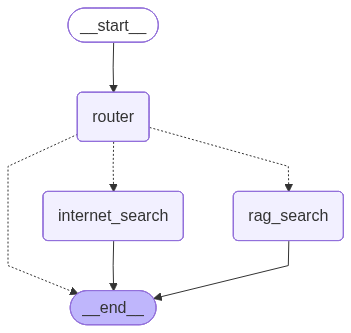

In [95]:
# Visualize our agent
try:
    from IPython.display import display, Image
    display(Image(ai_system.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(ai_system.get_graph().draw_ascii())

In [96]:
# Test your custom agent


def message_pretty_printer(response):
    for msg in response["messages"]:
        msg_type = type(msg).__name__
        content = msg.content if msg.content else f"[Tool calls: {msg.tool_calls}]" if hasattr(msg, 'tool_calls') and msg.tool_calls else "[No content]"
        print(f"  [{msg_type}]: {content[:200]}")

In [97]:
result= ai_system.invoke({"messages": [HumanMessage("whats the date today?")]})
message_pretty_printer(result)

  [HumanMessage]: whats the date today?
  [AIMessage]: [Tool calls: [{'name': 'get_current_time', 'args': {}, 'id': 'e300a7b3-0fa2-448e-88da-16428aa185c1', 'type': 'tool_call'}]]
  [ToolMessage]: The current date and time is: 2026-01-26 12:44:09
  [AIMessage]: Today’s date is 2026‑01‑26.


In [98]:
result2 = ai_system.invoke({"messages": [HumanMessage("whats the latest premier league scores?")]})
message_pretty_printer(result2)

  [HumanMessage]: whats the latest premier league scores?
  [AIMessage]: {"response":"Here are the most recent Premier League results available today:\n\n| Match | Score | Key moments |\n|-------|-------|--------------|\n| Arsenal vs Manchester United (25 Jan 2026) | **Ars


Which are indeed the latest scores at the time of executing the code:

(note however that the response format was not as expected or as clean as openAI GPT4 or GPT 5)

In [101]:
from rich.markdown import Markdown
Markdown(result2["messages"][-1].content)


{"response":"Here are the most recent Premier League results available today:\n\n| Match | Score | Key moments     
|\n|-------|-------|--------------|\n| Arsenal vs Manchester United (25 Jan 2026) | Arsenal 2 – 3 Man United |     
United came back from 1‑0 down to win 3‑2, with the decisive goal coming late in the second half. |\n| Burnley vs  
Tottenham Hotspur (24 Jan 2026) | Burnley 2 – 2 Spurs | Burnley took the lead in the 38th minute, Spurs equalised  
just before half‑time, and the match ended in a 2‑2 draw thanks to a last‑gasp header from Tottenham’s Cristian    
Romero. |\n\nSources\n- Arsenal vs Man United recap – ESPN                                                         
(https://www.espn.com/.../live-updates-crystal-palace-chelsea-arsenal-manchester-united-barcelona-premier-league-la
liga)\n- Burnley vs Spurs match report – Premier League                                                            
(https://premierleague.com/.../burnley-1-tottenham-hotspur-2-match-report-24-january-2026)\n\nThese are the latest 
scores we’ve got from the live‑update feeds. If you want the score for any other match that’s just finished, let me
know and I can check for that as well!"}

---
# Breakout Room #2
## Agentic RAG with Local Models

Now let's build a full **Agentic RAG** system from scratch using our local models!

We'll transition from the `aimakerspace` utilities to the **LangChain ecosystem**:

| Task | aimakerspace | LangChain |
|------|--------------|----------|
| Load Documents | `TextFileLoader` | `TextLoader` |
| Split Text | `CharacterTextSplitter` | `RecursiveCharacterTextSplitter` |
| Embeddings | Custom | `OllamaEmbeddings` |

## Task 5: Loading & Chunking with LangChain

Let's use LangChain's document loaders and text splitters.

**📚 Documentation:**
- [Document Loaders Conceptual Guide](https://python.langchain.com/docs/concepts/document_loaders/)
- [TextLoader Reference](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.text.TextLoader.html)
- [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)
- [Text Splitters Conceptual Guide](https://python.langchain.com/docs/concepts/text_splitters/)

In [102]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load the document using LangChain's TextLoader
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

print(f"Loaded {len(documents)} document(s)")
print(f"Total characters: {sum(len(doc.page_content) for doc in documents):,}")
print(f"\nDocument metadata: {documents[0].metadata}")

Loaded 1 document(s)
Total characters: 16,206

Document metadata: {'source': 'data/HealthWellnessGuide.txt'}


In [103]:
# Split documents using RecursiveCharacterTextSplitter
# This is more sophisticated than simple character splitting!

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
    # Default separators: ["\n\n", "\n", " ", ""]
    # Tries to keep paragraphs, then sentences, then words together
)

chunks = text_splitter.split_documents(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk (first 300 chars):")
print("-" * 50)
print(chunks[0].page_content[:300] + "...")

Split into 45 chunks

Sample chunk (first 300 chars):
--------------------------------------------------
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things you can do for your health. Regular physical activity can improve your brain health, help manage weigh...


## Task 6: Setting up Qdrant with Local Embeddings

Now we'll use **OllamaEmbeddings** with the `embeddinggemma` model - completely local!

**📚 Documentation:**
- [OllamaEmbeddings Reference](https://python.langchain.com/api_reference/ollama/embeddings/langchain_ollama.embeddings.OllamaEmbeddings.html)
- [Qdrant Vector Store Integration](https://python.langchain.com/docs/integrations/vectorstores/qdrant/)
- [Embedding Models Conceptual Guide](https://python.langchain.com/docs/concepts/embedding_models/)
- [EmbeddingGemma Overview (Google)](https://ai.google.dev/gemma/docs/embeddinggemma)

In [104]:
from langchain_ollama import OllamaEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize local embedding model
embedding_model = OllamaEmbeddings(model="embeddinggemma")

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")
print(f"Using local model: embeddinggemma")

Embedding dimension: 768
Using local model: embeddinggemma


In [105]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our wellness documents
collection_name = "wellness_knowledge_base_local"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

Created collection: wellness_knowledge_base_local


In [106]:
# Create vector store and add documents
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
print("Adding documents to vector store (this may take a moment with local embeddings)...")
vector_store.add_documents(chunks)
print(f"Added {len(chunks)} documents to vector store")

Adding documents to vector store (this may take a moment with local embeddings)...
Added 45 documents to vector store


In [107]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("How can I improve my sleep?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
Chapter 8: Improving Sleep Quality

Sleep hygiene refers to habits and practices that promote consistent, quality sleep.

Essential sleep hygiene practices:
- Maintain a consistent sleep schedule, eve...

--- Document 2 ---
Creating an optimal sleep environment:
- Temperature: 65-68 degrees Fahrenheit (18-20 Celsius)
- Darkness: Use blackout curtains or a sleep mask
- Quiet: Consider white noise machines or earplugs
- Co...

--- Document 3 ---
Types of insomnia:
- Acute insomnia: Short-term, often triggered by stress or life events
- Chronic insomnia: Long-term, occurring at least 3 nights per week for 3 months or more

Natural remedies for...


## Task 7: Creating a RAG Tool

Now let's wrap our retriever as a tool that the agent can use.

In [108]:
@tool
def search_wellness_knowledge(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips
    
    Args:
        query: The search query to find relevant wellness information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"RAG tool created: {search_wellness_knowledge.name}")

RAG tool created: search_wellness_knowledge


## Task 8: Building Agentic RAG from Scratch

Now let's put it all together - a complete agentic RAG system built from scratch!

In [109]:
# Define all tools for our RAG agent
rag_tools = [search_wellness_knowledge, calculate, get_current_time]

# Bind tools to the LLM
rag_llm_with_tools = llm.bind_tools(rag_tools)

print("Tools for RAG agent:")
for t in rag_tools:
    print(f"  - {t.name}")

Tools for RAG agent:
  - search_wellness_knowledge
  - calculate
  - get_current_time


In [110]:
# Define the RAG agent components
RAG_SYSTEM_PROMPT = """You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. ALWAYS search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable."""

def rag_agent_node(state: AgentState):
    """The RAG agent node - calls the LLM with wellness system prompt."""
    messages = [SystemMessage(content=RAG_SYSTEM_PROMPT)] + state["messages"]
    response = rag_llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Create tool node for RAG tools
rag_tool_node = ToolNode(rag_tools)

print("RAG agent node defined")

RAG agent node defined


In [111]:
# Build the RAG agent graph
rag_workflow = StateGraph(AgentState)

# Add nodes
rag_workflow.add_node("agent", rag_agent_node)
rag_workflow.add_node("tools", rag_tool_node)

# Set entry point
rag_workflow.add_edge(START, "agent")

# Add conditional edge
rag_workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "end": END}
)

# Add edge from tools back to agent
rag_workflow.add_edge("tools", "agent")

# Compile
rag_agent = rag_workflow.compile()

print("Agentic RAG built from scratch!")

Agentic RAG built from scratch!


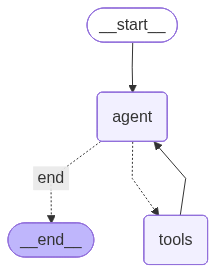

In [112]:
# Visualize the RAG agent
try:
    from IPython.display import display, Image
    display(Image(rag_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure:")
    print(rag_agent.get_graph().draw_ascii())

In [113]:
# Test the RAG agent
print("Testing Agentic RAG (with local models):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What are some tips for better sleep?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Agentic RAG (with local models):

Final Response:
{"response":"Here are several evidence‑based sleep‑hygiene tips that can help you fall asleep faster and enjoy deeper, more restorative rest:\n\n| Tip | Why it Works | Practical Steps |\n|-----|--------------|-----------------|\n| **Keep a consistent sleep schedule** | A regular circadian rhythm makes it easier for your body to know when to wind down. | Go to bed and wake up at the same time every day, even on weekends. |\n| **Create a calming pre‑sleep routine** | Engaging in relaxing activities lowers stress hormones and signals the brain that it’s time to sleep. | Try reading a book, gentle stretching, or a warm bath 30‑60 min before bed. |\n| **Optimize your bedroom environment** | The right temperature, light, and noise levels reduce arousal and support deeper sleep stages. | • Set the room to 65–68 °F (18–20 °C).  <br>• Use blackout curtains or a sleep mask to block light.  <br>• Consider a white‑noise machine or earplugs 

In [114]:
Markdown(response["messages"][-1].content)

{"response":"Here are several evidence‑based sleep‑hygiene tips that can help you fall asleep faster and enjoy     
deeper, more restorative rest:\n\n| Tip | Why it Works | Practical Steps                                           
|\n|-----|--------------|-----------------|\n| Keep a consistent sleep schedule | A regular circadian rhythm makes 
it easier for your body to know when to wind down. | Go to bed and wake up at the same time every day, even on     
weekends. |\n| Create a calming pre‑sleep routine | Engaging in relaxing activities lowers stress hormones and     
signals the brain that it’s time to sleep. | Try reading a book, gentle stretching, or a warm bath 30‑60 min before
bed. |\n| Optimize your bedroom environment | The right temperature, light, and noise levels reduce arousal and    
support deeper sleep stages. | • Set the room to 65–68 °F (18–20 °C).  • Use blackout curtains or a sleep mask to  
block light.  • Consider a white‑noise machine or earplugs if external noise is an issue. |\n| Limit screen        
exposure before bed | Blue light from phones, tablets, and TVs suppresses melatonin production, the hormone that   
signals sleep. | Turn off screens at least 1–2 hours before bedtime. Use night‑mode or a blue‑light filter if you  
must use a device. |\n| Watch caffeine and alcohol intake | Caffeine can stay in your system for 4–6 hours; alcohol
can fragment sleep. | Avoid caffeine after 2 PM and limit alcohol to no more than one drink a few hours before bed.
|\n| Mind your meals and exercise timing | Heavy meals and intense exercise close to bedtime can increase body     
temperature and stimulate the nervous system. | Finish dinner 2–3 hours before bed; finish vigorous exercise at    
least 3 hours prior, but light activity (e.g., a short walk) can promote sleepiness. |\n| Use relaxation techniques
| Stress and racing thoughts keep the brain aroused. | Practice progressive muscle relaxation, guided imagery, or a
brief meditation session before bed. |\n| Consider natural supplements (under professional guidance) | Certain     
herbs and minerals support melatonin production and muscle relaxation. | Chamomile or valerian root tea, or        
magnesium supplements (consult a healthcare provider first). |\n\nQuick Take‑away: Create a predictable,           
low‑stimulus bedtime routine, keep your bedroom cool, dark, and quiet, and avoid stimulants and heavy meals late in
the day. Small changes—like a 15‑minute wind‑down routine—can make a big difference over time.\n\nThese suggestions
are drawn from the Improving Sleep Quality chapter in our wellness knowledge base, which outlines sleep hygiene    
practices and natural remedies for better rest. If you have persistent sleep problems, consider speaking with a    
healthcare professional or a sleep therapist for personalized guidance."}

In [115]:
# Test with a complex query requiring both RAG and calculation
print("Testing with complex query:")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(
        content="I'm stressed and sleeping poorly. What should I do? Also, if I sleep 6 hours a night for a week, how many total hours is that?"
    )]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with complex query:

Final Response:
{"response":"I’m sorry you’re feeling so stressed and having trouble sleeping—it’s tough when both of those things pile up. Here are a few evidence‑based steps that can help calm your mind and improve sleep quality:\n\n1. **Establish a consistent sleep schedule** – Try to go to bed and wake up at the same time every day, even on weekends. Consistency signals your body’s internal clock and makes falling asleep easier.  (Source 1)\n2. **Create a wind‑down routine** – A relaxing pre‑bed ritual (e.g., reading a book, gentle stretching, a warm bath) can cue your body that it’s time to unwind.  (Source 1)\n3. **Optimize your sleep environment** – Keep the bedroom cool, dark, and quiet. Consider blackout curtains, earplugs, or a white‑noise machine if needed.  (Source 1)\n4. **Limit screens and stimulants** – Shut off phones, tablets, and TVs at least 1–2 hours before bed. Avoid caffeine after 2 PM and keep heavy meals, alcohol, and nicotine away f

In [116]:
Markdown(response["messages"][-1].content)

{"response":"I’m sorry you’re feeling so stressed and having trouble sleeping—it’s tough when both of those things 
pile up. Here are a few evidence‑based steps that can help calm your mind and improve sleep quality:\n\n1.         
Establish a consistent sleep schedule – Try to go to bed and wake up at the same time every day, even on weekends. 
Consistency signals your body’s internal clock and makes falling asleep easier.  (Source 1)\n2. Create a wind‑down 
routine – A relaxing pre‑bed ritual (e.g., reading a book, gentle stretching, a warm bath) can cue your body that  
it’s time to unwind.  (Source 1)\n3. Optimize your sleep environment – Keep the bedroom cool, dark, and quiet.     
Consider blackout curtains, earplugs, or a white‑noise machine if needed.  (Source 1)\n4. Limit screens and        
stimulants – Shut off phones, tablets, and TVs at least 1–2 hours before bed. Avoid caffeine after 2 PM and keep   
heavy meals, alcohol, and nicotine away from bedtime.  (Source 1)\n5. Manage stress during the day – Short, mindful
breathing or a brief meditation can reduce anxiety in the moment. Regular mindfulness practice has been shown to   
lower stress and improve focus.  (Source 3)\n6. Get regular movement – Aim for at least 30 minutes of moderate     
exercise most days, but finish any vigorous activity a few hours before bed so you’re not too energized when it’s  
time to sleep.  (Source 3)\n7. Connect socially – Talking to a supportive friend or family member, even if just for
a few minutes, can lessen feelings of overwhelm.  (Source 3)\n8. Set boundaries and manage your schedule –         
Prioritizing tasks, delegating when possible, and saying “no” when you’re stretched thin can reduce chronic stress.
(Source 3)\n\nIf you’re looking for quick relief when you’re feeling tense right now, try the 4‑7‑8 breathing      
exercise: breathe in for 4 seconds, hold for 7 seconds, and exhale slowly for 8 seconds. Repeat 3–4 times.\n\n###  
Calculating your total sleep\nIf you sleep 6 hours a night for a week (7 days), you’ll accumulate:\n\n6 hours/night
× 7 days = 42 hours total.  (calculated by the system)\n\nI hope these suggestions feel doable for you. Small,     
consistent changes can have a big impact over time. If you find that sleep problems persist or your stress feels   
unmanageable, consider speaking with a healthcare professional or therapist for personalized support. You’ve taken 
the first step by reaching out—keep moving forward with care and compassion for yourself!"}

In [117]:
# Test that the agent knows when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What is 125 * 8?")]
})

print("\nFinal Response:")
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG):

Final Response:
125 × 8 = **1000**.


In [142]:
[msg for msg in response["messages"] if isinstance(msg, ToolMessage)]

    


[ToolMessage(content='The result of 125 * 8 is 1000', name='calculate', id='57f8964e-9cb7-4d60-919f-6a62f3474e9c', tool_call_id='344a5394-a9ea-42a3-9907-adfa3aa82e6a')]

Tool was called👍

---
## ❓ Question #3:

Compare the experience of building an agent from scratch with LangGraph versus using `create_agent` from Session 3. What are the trade-offs between control and convenience? When would you choose one approach over the other?

##### Answer:
Its  quicker and less code to write to call create_agent in Langchain 1.x. 

The Langgraph approach is more convenient when there is complex custom logic such as a  workflow with many nodes and branching logic, that may or may not contain non-agentic steps,  or when you want to write some kind of agent that is not based on the ReAct pattern. 


That said, there's no reason one can't combine both approaches. Create_agent is still a langgraph object that can be inserted into a new langgraph workflow. So a complex workflow may consist of agents at some nodes, and non-agents at others where the agents could be written in langchain and the remainder in langggraph.

## ❓ Question #4:

We used local models (gpt-oss:20b and embeddinggemma) instead of cloud APIs. What are the advantages and disadvantages of this approach? 

##### Answer:
Data Privacy is the principle **advantage**, particularly for orgs that have a strong compliance or regulatory culture, since the data submitted for inference may stay within the org, and also generally permissive licencing requirements. There is also the possiblity of fine tuning such models on organisational specific data so that the model  becomes customised to the org, and that **may** outperform the best frontier models for a specific use case. Its possible that in very high-traffic environments, their relatively small footprint may result in reduced inference times or costs compared with pay per token 3rd party api calls (but as always, it depends...)

On the other hand, the **disadvantages** include it means maintaining our own MLOps to keep those models running reliably, hosting infrastructure (potentially not cheap - might requre multiple GPUs), and other supporting tech like KV Stores, logging, guardrails/content filters that come out of the box with some 3rd party providers. 

Finally the general capability of those models are unlikely to match that of frontier models, although it will vary by use case. My experiences of running this assignment was that it took me MUCH longer to get things working with local models than the openai api calls I used initially to develop my code. High memory requirements and slow inference was part of it, plus instruction following was not well observed as with the frontier models. I ended up abandoning using structured json output in my router node in **Activity1**, because it failed too often. A smaller model Qwen5b was tried, but the results were worse than gpt-oss20b 

---
## 🏗️ Activity #2: Extend the Agent with Memory

LangGraph supports **checkpointing** which enables conversation memory across invocations.

Your task: Add memory to the RAG agent so it can:
1. Remember previous questions in the conversation
2. Reference past context when answering new questions
3. Build on previous answers

Hint: Use `MemorySaver` from `langgraph.checkpoint.memory` and pass a `thread_id` in the config.

**📚 Documentation:**
- [LangGraph Persistence & Memory](https://langchain-ai.github.io/langgraph/concepts/persistence/)
- [How to add memory to your graph](https://langchain-ai.github.io/langgraph/how-tos/persistence/)
- [MemorySaver Reference](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver)

In [118]:
### YOUR CODE HERE ###

from langgraph.checkpoint.memory import MemorySaver

# Create a memory saver
memory = MemorySaver()

# Recompile the agent with checkpointing
# rag_agent_with_memory = rag_workflow.compile(checkpointer=memory)

# Test with a conversation that requires memory
# Use config={"configurable": {"thread_id": "conversation-1"}}


rag_agent_with_memory = rag_workflow.compile(checkpointer=memory)

config= {"configurable": {"thread_id": "1"}}

In [125]:
# Test your memory-enabled agent with a multi-turn conversation


query = HumanMessage("Hi I want to start eating heathier. Normally I like meat and potatoes for most evening meals, and McDonalds for lunch. Can you suggest alternatives")

result1 = rag_agent_with_memory.invoke({"messages": [query]}, config=config)

In [136]:
Markdown(result1['messages'][-1].content)

{"role":"assistant","content":"Great to hear you’re looking to add a bit more variety and nutrition to your meals! 
Here are some simple, balanced alternatives that still feel satisfying—plus a few quick “fast‑food‑style” ideas you
can whip up in minutes.\n\n---\n### 1. Evening meals (beyond meat & potatoes)\n| Current habit | Healthy swap | Why
it’s good | Quick prep tip |\n|---|---|---|---|\n| Roast or baked beef with mashed potatoes | Grilled salmon (or   
another fatty fish) + sweet‑potato mash | • Fatty fish supplies omega‑3s, heart‑friendly fats.\n• Sweet potatoes   
give complex carbs & beta‑carotene.\n• Lower sodium than many pre‑made sauces. | Grill the salmon while the        
potatoes bake—same timer!\n| Stir‑fried steak with rice | Stir‑fried tofu + brown rice + plenty of colorful veggies
| • Tofu is a plant‑based protein with a neutral taste.\n• Brown rice keeps you fuller longer. | Use a pre‑cut     
veggie mix (like a frozen stir‑fry blend) for 5‑minute cooking.\n| Beef & potato skillet | Turkey & roasted        
butternut‑squash skillet | • Turkey is leaner, lower in fat.\n• Squash adds sweetness and fiber. | Toss diced      
squash with olive oil & spices; roast 20 min, then add sliced turkey.\n\n---\n### 2. Lunches (beyond McDonald’s)\n|
Current habit | Healthy swap | Why it’s good | Quick prep tip |\n|---|---|---|---|\n| Big‑meal burger + fries |    
Turkey or veggie burger on a whole‑grain bun + sweet‑potato wedges | • Lean protein & whole grains.\n• Sweet       
potatoes reduce refined carbs. | Bake wedges in the oven while the burger cooks; 20 min at 425 °F.\n| Big Mac |    
Chicken‑lettuce wraps with avocado, salsa & a light Greek‑yogurt dressing | • Minimal carbs, high protein.\n•      
Avocado supplies healthy fats. | Wrap everything together in 5 min, take‑away ready.\n| McChicken | Mediterranean  
quinoa bowl: quinoa, cucumber, cherry tomatoes, feta, olives, lemon‑olive‑oil dressing | • Quinoa is complete      
protein.\n• Lots of veggies & healthy fats. | Cook quinoa ahead of time; assemble in a jar for                     
on‑the‑go.\n\n---\n### 3. Quick, everyday‑day healthy ideas\n1. Sheet‑pan dinners: Toss chicken thighs, broccoli,  
carrots, and olive oil on a sheet pan; roast 30 min. \n2. Oven‑baked fish sticks: Coat cod or tilapia strips in    
almond flour & spices; bake 15 min. \n3. Stuffed peppers: Fill bell peppers with brown rice, black beans, corn,    
salsa, and cheese; bake 25 min. \n4. Smoothie bowls: Blend frozen berries, spinach, a scoop of protein powder, and 
almond milk. Top with nuts & seeds. \n5. Veggie‑filled omelets: Add spinach, mushrooms, onions, and a sprinkle of  
cheese to a quick scramble.\n\n---\n### Tips for a sustainable switch\n1. Batch‑cook staples: Roast a large tray of
veggies, cook quinoa or brown rice in bulk, and keep ready‑to‑heat portions in the fridge. \n2. Keep healthy snacks
handy: Nuts, cut veggies, fruit, Greek yogurt, or hummus. This reduces the urge to reach for fast food. \n3. Mind  
the portion size: Even healthy meals can tip the scale if the portions are too large. Aim for a plate that’s about 
half veggies, a quarter protein, and a quarter complex carb. \n4. Flavor with herbs & spices: Reducing salt doesn’t
mean losing taste—try cumin, paprika, rosemary, or fresh lemon juice. \n5. Plan your “fast‑food” style meals: Prep 
a bag of frozen veggies, a bag of pre‑measured spices, and a protein source you like. That way you’re just adding  
the extra ingredients to your skillet or oven.\n\n---\nYou’ve already taken the first step by asking for help—now  
it’s just a matter of mixing, matching, and experimenting. Let me know if you’d like recipes for any of the        
suggestions above, or if you’re interested in meal‑prep schedules, grocery lists, or tracking your nutrition. Happy
cooking and enjoy your healthier journey! 🌱✨"}

In [138]:
query = HumanMessage("Thanks. I also want to get fitter, and lose some weight. Any suggestions? Give me a short summary of all the avice you've provided so far")

result2 = rag_agent_with_memory.invoke({"messages": [query]}, config=config)
result2['messages'][-1].content

'{"role":"assistant","content":"Here’s a quick recap of the healthy‑eating and fitness tips I’ve shared:\\n\\n---\\n## 1️⃣\u202fEating\u202fSmarter\\n| Situation | Healthy Swap | Why It Helps |\\n|---|---|---|\\n| **Evening meat\u202f&\u202fpotatoes** | • Grilled salmon + sweet‑potato mash\\n• Stir‑fried tofu + brown rice\\n• Turkey + roasted butternut‑squash skillet | • Lower saturated fat & refined carbs\\n• More omega‑3s, fiber & micronutrients | \\n| **McDonald’s lunch** | • Turkey/veggie burger + sweet‑potato wedges\\n• Chicken‑lettuce wraps with avocado\\n• Mediterranean quinoa bowl | • Lean protein, whole grains & veggies\\n• Fewer added sugars & sodium |\\n| **Quick‑prep ideas** | • Sheet‑pan dinners, oven‑baked fish sticks, stuffed peppers, smoothie bowls, veggie‑filled omelets | • Saves time, keeps meals balanced & satisfying |\\n\\n---\\n## 2️⃣\u202fGetting Fitter & Shedding Weight\\n1. **Mix cardio & strength** – 150\u202fmin of moderate cardio + 2‑3 strength sessions per w

In [139]:
Markdown(result2['messages'][-1].content)

{"role":"assistant","content":"Here’s a quick recap of the healthy‑eating and fitness tips I’ve shared:\n\n---\n## 
1️⃣ Eating Smarter\n| Situation | Healthy Swap | Why It Helps |\n|---|---|---|\n| Evening meat & potatoes | •       
Grilled salmon + sweet‑potato mash\n• Stir‑fried tofu + brown rice\n• Turkey + roasted butternut‑squash skillet | •
Lower saturated fat & refined carbs\n• More omega‑3s, fiber & micronutrients | \n| McDonald’s lunch | •            
Turkey/veggie burger + sweet‑potato wedges\n• Chicken‑lettuce wraps with avocado\n• Mediterranean quinoa bowl | •  
Lean protein, whole grains & veggies\n• Fewer added sugars & sodium |\n| Quick‑prep ideas | • Sheet‑pan dinners,   
oven‑baked fish sticks, stuffed peppers, smoothie bowls, veggie‑filled omelets | • Saves time, keeps meals balanced
& satisfying |\n\n---\n## 2️⃣ Getting Fitter & Shedding Weight\n1. Mix cardio & strength – 150 min of moderate      
cardio + 2‑3 strength sessions per week. | 2. Progressive overload – gradually increase weight or reps to keep     
muscles challenged. | 3. Stay active daily – walk, bike, or take stairs when possible. | 4. Track portions – aim   
for plate split: ½ veggies, ¼ protein, ¼ complex carb. | 5. Hydrate & rest – 2‑3 L water/day, 7‑9 h sleep, and 1‑2 
recovery days/week. |\n\n---\n## 3️⃣ Practical Take‑aways\n- Batch‑cook staples (rice, roasted veggies) to avoid    
fast‑food temptation. | \n- Keep healthy snacks (nuts, fruit, yogurt) on hand. | \n- Use herbs/spices to keep meals
flavorful without extra salt. | \n- Plan your “fast‑food” style meals in advance (e.g., pre‑measured spices,       
protein packs). |\n- Track progress (food diary + weekly weigh‑ins) to stay accountable. |\n\nRemember: Consistency
beats perfection. Small, sustainable changes—like swapping one meal a day and adding a 20‑minute walk—will add up  
over time. Keep it enjoyable, stay hydrated, and celebrate every milestone! 🚀🍏"                                  

}

Ok. So its still remembering my eating perferences from the first query👍

---
## Summary

In this session, we:

1. **Built agents from scratch** using LangGraph's low-level primitives (StateGraph, nodes, edges)
2. **Used local open-source models** with Ollama (gpt-oss:20b + embeddinggemma)
3. **Transitioned to LangChain** for document loading and text splitting
4. **Set up observability** with LangSmith tracing
5. **Created an Agentic RAG system** that intelligently decides when to retrieve information

### Key Takeaways:

- **StateGraph** gives you full control over agent architecture
- **Conditional edges** enable dynamic routing based on LLM decisions
- **Local models** provide privacy and cost savings, with trade-offs in performance
- **LangSmith** provides crucial visibility regardless of where your models run

### What's Next?

Now that you understand the fundamentals, you can:
- Add more sophisticated routing logic
- Implement human-in-the-loop patterns
- Build multi-agent systems
- Deploy to production with LangGraph Platform

**📚 Further Reading:**
- [LangGraph How-To Guides](https://langchain-ai.github.io/langgraph/how-tos/)
- [Human-in-the-Loop Patterns](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/)
- [Multi-Agent Architectures](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)
- [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)